In [1]:
#计算finger efficiency：key之间距离/path长度 (histogram)
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def readPickle(filename):
    import pickle

    # reload a file to a variable
    with open(filename, 'rb') as file:
        a_dict1 =pickle.load(file)

    return a_dict1

In [3]:
def writePickle(filename,dictionary):
    import pickle
    # pickle a variable to a file
    file = open(filename, 'wb')
    pickle.dump(dictionary, file)
    file.close()

In [4]:
def KeyToXY(key):
    keys_ = ['q','w','e','r','t','y','u','i','o','p','å','a','s','d','f','g','h','j','k','l','ö','ä','z'
            ,'x','c','v','b','n','m','<',' ','enter']
    xs = [566, 697, 828, 959, 1090, 1221, 1352, 1483, 1614, 1745, 1876, 566, 697, 828, 959
         , 1090, 1221, 1352, 1483, 1614, 1745, 1876, 828, 959, 1090, 1221, 1352, 1483, 1614
         , 1810, 1193, 1737]
    ys = [1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 1955, 2185, 2185
         , 2185, 2185, 2185, 2185, 2185, 2185, 2185, 2185, 2185, 2415, 2415, 2415, 2415
         , 2415, 2415, 2415, 2415, 2645, 2645]

    if key not in keys_:
        return []
    else:
        p = keys_.index(key)
        return [xs[p], ys[p]]

In [5]:
def dis(posX1, posY1, posX2, posY2):
    import math
    
    ofx = posX2-posX1
    ofy = posY2-posY1
    return [math.sqrt(ofx*ofx+ofy*ofy),ofx,ofy]

In [6]:
dictFix = readPickle('./pkl/eyeMovementData.pkl')
dictFin = readPickle('./pkl/fingerMovementData.pkl')

In [7]:
print(dictFix['101']['1']['20'].keys())

dict_keys(['systemtime', 'trialtime', 'key', 'touchx', 'touchy', 'x', 'y', 'xf', 'yf', 'fixnum', 'fixdur', 't', 'IKI', 'errorMessage'])


In [8]:
def drawTimeHistogram(yList,title):
    plt.hist(yList, bins='auto')  # arguments are passed to np.histogram
    plt.title(title)
    plt.savefig(title+".png")
    plt.show()

In [9]:
def drawGraph(xlist, ylist, title, xlable,ylable):
    import matplotlib.pyplot as plt
  
    t = title
    
    #去掉 IKI 结果中的 outlier
    #temp = rejectOutliers(xlist, ylist)
    #xlist1 = temp[0]
    #ylist1 = temp[1]
    
    
    yfit = []
    #a,b = np.polyfit(xlist, ylist, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(xlist, ylist)
    print('Corr = '+str(r_value))
    
    for item in xlist:
        yfit.append(slope*item+intercept)
   
    plt.xlabel(xlable)  
    plt.ylabel(ylable)
    plt.title(t)
    
    
    plt.plot(xlist, ylist ,'ro', alpha=.5,label = 'Corr:'+str(round(r_value,2)))
    #plt.plot(xlist1, ylist1 ,'ro', alpha=.5)
    
    plt.plot(xlist,yfit, linewidth = 2)


    plt.savefig(t+".png")
   
    plt.show()

In [10]:
def rejectOutliers1(dataY):
    u = np.mean(dataY)
    s = np.std(dataY)
    dataY1 = []
    rejected = []
    for i in range(len(dataY)):
        if (u - 2 * s) < dataY[i] < (u + 2 * s):
            dataY1.append(dataY[i])
        else:
            rejected.append(dataY[i])   
    if len(dataY)!=len(dataY1):
        print('outlier rejected:')
        print(rejected)
    return dataY1

In [11]:
def rejectOutliers2(dataX, dataY):
    u = np.mean(dataY)
    s = np.std(dataY)
    print([u,s])
    dataX1 = []
    dataY1 = []
    rejected = []
    for i in range(len(dataY)):
        if (u - 2 * s) < dataY[i] < (u + 2 * s):
            dataX1.append(dataX[i])
            dataY1.append(dataY[i])
        else:
            rejected.append(dataY[i])   
    if len(dataY)!=len(dataY1):
        print('outlier rejected:')
        print(rejected)
    return [dataX1,dataY1]

In [15]:
#计算finger efficiency：key之间距离/path长度

block = '2'
IKIPerSentence = []
fingerMEPerSentence = []

for subject in dictFin.keys():
    for sentence in dictFin[subject][block].keys():
        
        #存放每次点击Key时，实际key之间的距离(interKeyDistance)和手指移动距离(pathlength)的list
        interKeyDistance = []
        fingerPathlength = []
        for index in range(len(dictFin[subject][block][sentence]['key'])):
            if index==0 or index==len(dictFin[subject][block][sentence]['key'])-1:
                continue
            else:
                lastkey = KeyToXY(dictFin[subject][block][sentence]['key'][index-1])
                thiskey = KeyToXY(dictFin[subject][block][sentence]['key'][index])
                #如果lastkey和thiskey中有任何一个key不属于定义字符集（如，A）则跳过计算
                if len(lastkey)*len(thiskey)==0:
                    continue
                interKeyDistance.append(dis(lastkey[0],lastkey[1],thiskey[0],thiskey[1])[0])

                templength = 0
                              
                for i in range(len(dictFin[subject][block][sentence]['x1'][index])+1):
                    #这个path的计算应该始于lastkey，结束于thiskey的坐标位置
                    #在计算path的时候相当于在两端点加上两个key的坐标
                    if len(dictFin[subject][block][sentence]['x1'][index])!=0:
                        if i==0:
                            #第一个点之前插入lastkey的位置
                            x1 = lastkey[0]
                            y1 = lastkey[1]
                            x2 = dictFin[subject][block][sentence]['x1'][index][i]
                            y2 = dictFin[subject][block][sentence]['y1'][index][i]


                        elif i==len(dictFin[subject][block][sentence]['x1'][index]):
                            #最后一个点之后插入thiskey的位置
                            x1 = dictFin[subject][block][sentence]['x1'][index][i-1]
                            y1 = dictFin[subject][block][sentence]['y1'][index][i-1]
                            x2 = thiskey[0]
                            y2 = thiskey[1]
                        else:
                            x1 = dictFin[subject][block][sentence]['x1'][index][i-1]
                            y1 = dictFin[subject][block][sentence]['y1'][index][i-1]
                            x2 = dictFin[subject][block][sentence]['x1'][index][i]
                            y2 = dictFin[subject][block][sentence]['y1'][index][i]
                        templength = templength + dis(x2,y2,x1,y1)[0]
                    else:
                        continue
                fingerPathlength.append(templength)
                
        if sum(fingerPathlength)!=0:
            totalInterKeyDistance = sum(interKeyDistance)
            totalPathlength = sum(fingerPathlength)
            ef = totalInterKeyDistance/totalPathlength
            if ef<=1:
                IKIPerSentence.append(np.mean(len(dictFin[subject][block][sentence]['IKI'])))
                fingerMEPerSentence.append(ef)


outlier rejected:
[0.3523303187114339, 0.7853243194190659, 0.787111890269482, 0.7613003801920928, 0.7609688075497656, 0.7826925007440468, 0.7732750475823311, 0.7773815411062757, 0.3105572770267433, 0.2698063348184617, 0.25920126852331665, 0.30165814247185263, 0.3143172552655525, 0.2757680258020602, 0.2941195618497202, 0.25180295105477385, 0.26300269800831133, 0.2872085813503769, 0.28881451997252605, 0.33332178144998176, 0.2918382518330512, 0.30066185887014557, 0.2535987174585683, 0.23703981964973186, 0.2842681496689057, 0.283010444129811, 0.26482785902943456, 0.2693856680687824, 0.39120847336503284, 0.1050033323668743, 0.3819559950924746, 0.3854589114186534, 0.3500652106027704, 0.28414933638401035]


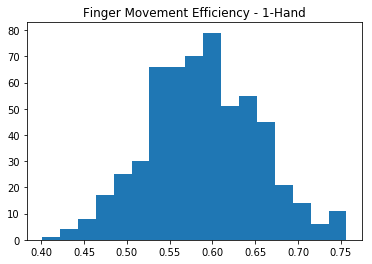

In [16]:
#画图Histogram
drawTimeHistogram(rejectOutliers1(fingerMEPerSentence),'Finger Movement Efficiency - 1-Hand')


[25.709784411276949, 9.8538416944488958]
outlier rejected:
[48.0, 46.0, 48.0, 48.0, 48.0, 51.0, 50.0, 49.0, 101.0, 49.0, 5.0, 46.0, 48.0, 48.0, 50.0, 47.0, 69.0, 48.0, 155.0, 51.0, 57.0, 53.0, 5.0]
Corr = -0.139849529569


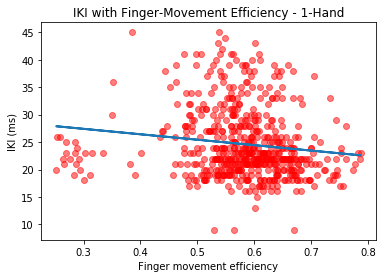

In [17]:
#画图散点图
xy = rejectOutliers2(fingerMEPerSentence,IKIPerSentence)
drawGraph(xy[0],xy[1], 'IKI with Finger-Movement Efficiency - 1-Hand', 'Finger movement efficiency','IKI (ms)')

In [18]:
def getFinger(dictFin,subject,block,sentence,index):
    #返回点击key的手指标号，1 hand1， 2 hand2， 0 数据不足
    
    if block=='2':
        #如果是block 2，则一定是finger 1
        return 1
    else:
        currentInfo = dictFin[subject][block][sentence]
    
        keyPressingTime = currentInfo['trialtime'][index]
        touchx = currentInfo['touchx'][index]
        touchy = currentInfo['touchy'][index]

        if len(currentInfo['t'])!=0:
            len1 = len(currentInfo['t'][index])
            len2 = len(currentInfo['t'][index+1])
            if len1!=0 and len2!=0:
                #通过点击key之前最后一个figer和点击键之后的第一个finger的连线，和时间位置
                #计算finger在某时间点上的坐标位置
                finTimeBeforeKeyPressing = currentInfo['t'][index][len1-1]
                finTimeAfterKeyPressing = currentInfo['t'][index+1][0]

                #hand 1
                x11,y11 = currentInfo['x1'][index][len1-1],currentInfo['y1'][index][len1-1]
                x12,y12 = currentInfo['x1'][index+1][0],currentInfo['y1'][index+1][0]

                #hand 2
                x21,y21 = currentInfo['x2'][index][len1-1],currentInfo['y2'][index][len1-1]
                x22,y22 = currentInfo['x2'][index+1][0],currentInfo['y2'][index+1][0]

                if finTimeBeforeKeyPressing<=keyPressingTime<=finTimeAfterKeyPressing:
                    #如果当前点击key的时间介于(点击当前key之前最后一个fixation数据行的采样时间)
                    #与(点击当前key之后第一个fixation数据行的采样时间)之间
                    #则通过这两个时间点fixation的位置和时间计算（假设眼球匀速运动）到key pressing的时间点时，fixation的坐标
                    a = (keyPressingTime-finTimeBeforeKeyPressing)/(finTimeAfterKeyPressing-finTimeBeforeKeyPressing)
                    b = (finTimeAfterKeyPressing-keyPressingTime)/(finTimeAfterKeyPressing-finTimeBeforeKeyPressing)
                    #hand 1 点击key时刻的估计位置
                    x1 = b*x11+a*x12
                    y1 = b*y11+a*y12
                    #hand 2 点击key时刻的估计位置
                    x2 = b*x21+a*x22
                    y2 = b*y21+a*y22

                    #判断点击key的时刻，哪个手距离key更近
                    #即为点击key的手指
                    finger1touch = np.sqrt((touchx-x1)*(touchx-x1)+(touchy-y1)*(touchy-y1))
                    finger2touch = np.sqrt((touchx-x2)*(touchx-x2)+(touchy-y2)*(touchy-y2))
                    if finger1touch>finger2touch:
                        return 2
                    else:
                        return 1 

                else:
                    print('----------------------------------------')
                    print('before')
                    print(currentInfo['t'][index])
                    print('after')
                    print(currentInfo['t'][index+1])
                    print('keyPressingTime')
                    print(keyPressingTime)
                    print('----------------------------------------')
                    return 0
            else:
                return 0
        else:
            return 0
    
    

In [19]:
#计算finger efficiency：key之间距离/path长度


block = '1'
IKIPerSentence = []
fingerMEPerSentence = []

for subject in dictFin.keys():
    for sentence in dictFin[subject][block].keys():
        
        #存放每次点击Key时，实际key之间的距离(interKeyDistance)和手指移动距离(pathlength)的list
        interKeyDistance = []
        fingerPathlength = []
        for index in range(len(dictFin[subject][block][sentence]['key'])):
            if index==0 or index==len(dictFin[subject][block][sentence]['key'])-1:
                continue
            else:
                
                hand = getFinger(dictFin,subject,block,sentence,index)
                if hand==0:
                    continue
                elif hand==1:
                    xkey = 'x1'
                    ykey = 'y1'
                    print('index = '+str(index)+'  hand = '+ str(hand))
                elif hand==2:
                    xkey = 'x2'
                    ykey = 'y2'
                    print('index = '+str(index)+'  hand = '+ str(hand))
                
                lastkey = KeyToXY(dictFin[subject][block][sentence]['key'][index-1])
                thiskey = KeyToXY(dictFin[subject][block][sentence]['key'][index])
                #如果lastkey和thiskey中有任何一个key不属于定义字符集（如，A）则跳过计算
                if len(lastkey)*len(thiskey)==0:
                    continue
                interKeyDistance.append(dis(lastkey[0],lastkey[1],thiskey[0],thiskey[1])[0])

                templength = 0
                              
                for i in range(len(dictFin[subject][block][sentence][xkey][index])+1):
                    #这个path的计算应该始于lastkey，结束于thiskey的坐标位置
                    #在计算path的时候相当于在两端点加上两个key的坐标
                    if len(dictFin[subject][block][sentence][xkey][index])!=0:
                        if i==0:
                            #第一个点之前插入lastkey的位置
                            x1 = lastkey[0]
                            y1 = lastkey[1]
                            x2 = dictFin[subject][block][sentence][xkey][index][i]
                            y2 = dictFin[subject][block][sentence][ykey][index][i]


                        elif i==len(dictFin[subject][block][sentence][xkey][index]):
                            #最后一个点之后插入thiskey的位置
                            x1 = dictFin[subject][block][sentence][xkey][index][i-1]
                            y1 = dictFin[subject][block][sentence][ykey][index][i-1]
                            x2 = thiskey[0]
                            y2 = thiskey[1]
                        else:
                            x1 = dictFin[subject][block][sentence][xkey][index][i-1]
                            y1 = dictFin[subject][block][sentence][ykey][index][i-1]
                            x2 = dictFin[subject][block][sentence][xkey][index][i]
                            y2 = dictFin[subject][block][sentence][ykey][index][i]
                        templength = templength + dis(x2,y2,x1,y1)[0]
                    else:
                        continue
                fingerPathlength.append(templength)
                
        if sum(fingerPathlength)!=0:
            totalInterKeyDistance = sum(interKeyDistance)
            totalPathlength = sum(fingerPathlength)
            ef = totalInterKeyDistance/totalPathlength
            if ef<=1:
                IKIPerSentence.append(np.mean(len(dictFin[subject][block][sentence]['IKI'])))
                fingerMEPerSentence.append(ef)


index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 1
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 2
index = 10  hand = 2
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 19  hand = 1
index = 20  hand = 1
index = 21  hand = 1
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 1
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 2
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 19  hand = 2
index = 20  hand = 1
index = 21  hand = 1
index = 22  hand = 1
index = 23  hand = 2
index = 24  hand = 1
index = 25  hand = 1
index = 26  hand = 1
index = 1  hand = 2
index = 2  

index = 5  hand = 1
index = 6  hand = 2
index = 7  hand = 2
index = 8  hand = 2
index = 9  hand = 2
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 2
index = 13  hand = 2
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 2
index = 17  hand = 2
index = 18  hand = 2
index = 19  hand = 2
index = 1  hand = 2
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 2
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 2
index = 9  hand = 2
index = 10  hand = 1
index = 11  hand = 2
index = 12  hand = 2
index = 13  hand = 2
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 2
index = 1  hand = 2
index = 2  hand = 2
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 2
index = 9  hand = 2
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 2
index = 13  hand = 1
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 2
index = 17  hand = 2
index = 18  han

index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 2
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 2
index = 17  hand = 1
index = 18  hand = 2
index = 19  hand = 2
index = 20  hand = 2
index = 21  hand = 1
index = 22  hand = 1
index = 23  hand = 1
index = 24  hand = 2
index = 25  hand = 1
index = 26  hand = 1
index = 1  hand = 1
index = 2  hand = 2
index = 3  hand = 1
index = 4  hand = 1
index = 5  hand = 2
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 19  hand = 1
index = 20  hand = 2
index = 21  hand = 1
index = 22  hand = 2
index = 23  hand = 2
index = 24  hand = 1
index = 25  hand = 1
index = 26  hand = 2
index = 27  hand = 1
index = 28  hand = 1
index = 29  hand = 2
index = 30  hand = 1
in

index = 50  hand = 2
index = 51  hand = 2
index = 52  hand = 1
index = 53  hand = 2
index = 54  hand = 1
index = 1  hand = 2
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 2
index = 9  hand = 1
index = 10  hand = 2
index = 11  hand = 2
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 2
index = 15  hand = 1
index = 16  hand = 2
index = 17  hand = 1
index = 18  hand = 1
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 1
index = 6  hand = 2
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 2
index = 11  hand = 1
index = 12  hand = 2
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 2
index = 18  hand = 2
index = 19  hand = 1
index = 1  hand = 2
index = 2  hand = 2
index = 3  hand = 1
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 2
index = 7  hand 

index = 20  hand = 1
index = 21  hand = 1
index = 22  hand = 1
index = 23  hand = 2
index = 24  hand = 1
index = 25  hand = 1
index = 26  hand = 1
index = 27  hand = 1
index = 28  hand = 1
index = 29  hand = 2
index = 30  hand = 1
index = 31  hand = 1
index = 32  hand = 1
index = 33  hand = 1
index = 34  hand = 1
index = 35  hand = 2
index = 36  hand = 1
index = 37  hand = 1
index = 38  hand = 2
index = 39  hand = 2
index = 40  hand = 1
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 1
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 2
index = 14  hand = 1
index = 15  hand = 2
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 19  hand = 2
index = 20  hand = 1
index = 21  hand = 1
index = 22  hand = 1
index = 23  hand = 1
index = 24  hand = 2
index = 25  hand = 1
index = 26  hand = 1
index = 27  hand = 1
i

index = 20  hand = 1
index = 21  hand = 2
index = 22  hand = 2
index = 23  hand = 1
index = 24  hand = 2
index = 25  hand = 2
index = 26  hand = 2
index = 27  hand = 1
index = 28  hand = 2
index = 29  hand = 2
index = 30  hand = 2
index = 31  hand = 2
index = 32  hand = 2
index = 33  hand = 2
index = 34  hand = 2
index = 35  hand = 2
index = 36  hand = 2
index = 37  hand = 2
index = 38  hand = 2
index = 39  hand = 2
index = 40  hand = 2
index = 41  hand = 2
index = 42  hand = 2
index = 43  hand = 2
index = 44  hand = 2
index = 45  hand = 1
index = 46  hand = 2
index = 47  hand = 1
index = 48  hand = 2
index = 49  hand = 1
index = 50  hand = 2
index = 51  hand = 2
index = 52  hand = 1
index = 53  hand = 2
index = 54  hand = 2
index = 55  hand = 2
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 2
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 1
index = 9  hand = 2
index = 10  hand = 2
index = 11  hand = 2
index = 12  hand = 2
i

index = 6  hand = 2
index = 7  hand = 2
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 2
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 1
index = 9  hand = 2
index = 10  hand = 2
index = 11  hand = 2
index = 12  hand = 2
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 1
index = 1  hand = 2
index = 2  hand = 2
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 1
index = 6  hand = 2
index = 7  hand = 2
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 2
index = 11  hand = 2
index = 12  hand = 2
index = 13  hand = 2
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 2
index = 17  hand = 1
index = 18  hand = 2
index = 19  ha

index = 12  hand = 1
index = 13  hand = 2
index = 14  hand = 1
index = 15  hand = 2
index = 16  hand = 2
index = 1  hand = 1
index = 4  hand = 1
index = 5  hand = 2
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 2
index = 9  hand = 2
index = 10  hand = 1
index = 11  hand = 2
index = 12  hand = 2
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 2
index = 17  hand = 1
index = 18  hand = 1
index = 19  hand = 2
index = 20  hand = 2
index = 21  hand = 2
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 2
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 19  hand = 1
index = 20  hand = 2
index = 21  hand = 1
index = 22  hand = 2
index = 23  hand = 2
index = 24  hand = 2
index = 

index = 24  hand = 1
index = 25  hand = 1
index = 26  hand = 1
index = 27  hand = 1
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 2
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 2
index = 13  hand = 2
index = 14  hand = 1
index = 15  hand = 2
index = 16  hand = 2
index = 17  hand = 2
index = 18  hand = 1
index = 19  hand = 1
index = 1  hand = 1
index = 2  hand = 1
index = 3  hand = 2
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 2
index = 8  hand = 2
index = 9  hand = 1
index = 10  hand = 2
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 2
index = 18  hand = 2
index = 19  hand = 1
index = 20  hand = 2
index = 21  hand = 1
index = 22  hand = 2
index = 23  hand = 2
index = 24  hand = 1
index = 25  hand = 1
index = 1 

index = 10  hand = 2
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 2
index = 15  hand = 1
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 2
index = 19  hand = 1
index = 20  hand = 1
index = 21  hand = 1
index = 22  hand = 2
index = 23  hand = 1
index = 24  hand = 1
index = 25  hand = 1
index = 26  hand = 1
index = 27  hand = 2
index = 28  hand = 1
index = 29  hand = 1
index = 30  hand = 2
index = 31  hand = 1
index = 32  hand = 1
index = 33  hand = 1
index = 34  hand = 1
index = 35  hand = 1
index = 36  hand = 1
index = 37  hand = 1
index = 38  hand = 1
index = 39  hand = 2
index = 40  hand = 1
index = 41  hand = 1
index = 42  hand = 1
index = 43  hand = 1
index = 44  hand = 1
index = 45  hand = 1
index = 46  hand = 1
index = 47  hand = 1
index = 48  hand = 1
index = 49  hand = 1
index = 50  hand = 2
index = 51  hand = 1
index = 52  hand = 2
index = 53  hand = 1
index = 54  hand = 1
index = 55  hand = 1
index = 56  hand = 2
index = 57  h

index = 1  hand = 1
index = 2  hand = 2
index = 1  hand = 1
index = 2  hand = 2
index = 3  hand = 1
index = 4  hand = 1
index = 5  hand = 1
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 2
index = 9  hand = 2
index = 10  hand = 2
index = 11  hand = 2
index = 12  hand = 2
index = 13  hand = 1
index = 14  hand = 2
index = 15  hand = 2
index = 16  hand = 1
index = 17  hand = 1
index = 18  hand = 1
index = 1  hand = 2
index = 2  hand = 1
index = 3  hand = 1
index = 4  hand = 2
index = 5  hand = 2
index = 6  hand = 1
index = 7  hand = 1
index = 8  hand = 1
index = 9  hand = 1
index = 10  hand = 1
index = 11  hand = 1
index = 12  hand = 1
index = 13  hand = 1
index = 14  hand = 1
index = 15  hand = 1
index = 16  hand = 2
index = 17  hand = 2
index = 18  hand = 1
index = 19  hand = 1
index = 20  hand = 2
index = 21  hand = 1
index = 22  hand = 1
index = 23  hand = 1
index = 24  hand = 1
index = 25  hand = 1
index = 26  hand = 1
index = 27  hand = 2
index = 28  hand = 2
index = 29  

outlier rejected:
[0.23029452489077912, 0.792910774836298, 0.24944943681144494, 0.30395405053351904, 0.2882971033178817, 0.22944524714234538, 0.30606649915439466, 0.25765582301878637, 0.31781767772683917, 0.2797848936377212, 0.2776492763834815, 0.27092595760532034, 0.1849993708672679, 0.2327470307227084, 0.30096182473674843, 0.25735352368846776, 0.3513775617865832, 0.773696627595242, 0.20171343518626556, 0.2657440574776587, 0.3413054945782975, 0.16523286867086678, 0.34812126154296597, 0.21973757330917185, 0.34685167752067503, 0.34300778472994886, 0.3446721608913481, 0.2898893217879233]


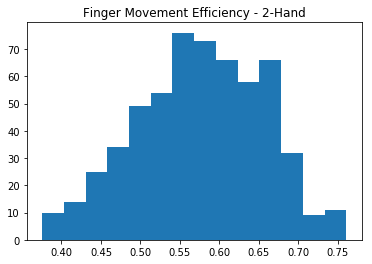

In [20]:
#画图Histogram
drawTimeHistogram(rejectOutliers1(fingerMEPerSentence),'Finger Movement Efficiency - 2-Hand')

[27.821487603305783, 11.147005724857758]
outlier rejected:
[51.0, 52.0, 59.0, 56.0, 52.0, 54.0, 57.0, 136.0, 51.0, 52.0, 61.0, 63.0, 75.0, 51.0, 69.0, 77.0, 51.0, 53.0, 62.0, 85.0, 51.0, 55.0, 74.0, 4.0, 53.0, 51.0, 59.0, 5.0, 66.0]
Corr = -0.125376856625


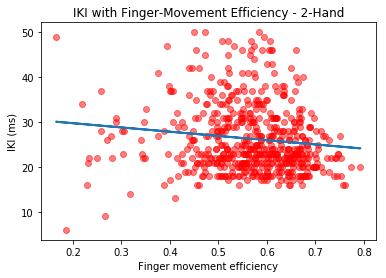

In [21]:
#画图散点图
xy = rejectOutliers2(fingerMEPerSentence,IKIPerSentence)
drawGraph(xy[0],xy[1], 'IKI with Finger-Movement Efficiency - 2-Hand', 'Finger movement efficiency','IKI (ms)')